# 01 - Dimensionality Reduction & Sampling for HSI

## 1. Objective and Hypothesis

Following the EDA phase, we identified that Hyperspectral Imagery (HSI) suffers from the **Hughes Phenomenon** (high dimensionality, highly correlated bands) and extreme **Class Imbalance** with very few labeled samples available.

### The Mathematical Problem:
Given an HSI dataset $X \in \mathbb{R}^{D \times N}$ (where $D$ is the number of spectral bands and $N$ is the number of pixels), we seek a projection matrix $P \in \mathbb{R}^{D \times d}$ ($d \ll D$) mapping the data to $Y = P^T X$.

### Baselines:
1. **PCA**: $\max_P \text{Tr}(P^T C_X P)$. Unsupervised, maximizes variance. Susceptible to high-variance noise.
2. **MNF**: $\max_P \frac{\text{Tr}(P^T C_X P)}{\text{Tr}(P^T C_N P)}$. Maximizes Signal-to-Noise Ratio by whitening the noise covariance $C_N$.
3. **LDA**: $\max_P \frac{\text{Tr}(P^T S_B P)}{\text{Tr}(P^T S_W P)}$. Supervised, maximizes class separability. Fails when samples per class $< D$ due to singular within-class scatter $S_W$.

### Proposed Focus: Local Similarity Projection (LSP)
LSP constructs an adjacency graph $W$ to capture local manifold structures. The projection minimizes the distance between connected neighbors in the latent space:
$$ \min_{P} \frac{\text{Tr}(P^T X L X^T P)}{\text{Tr}(P^T X D X^T P)} $$
Solved via the generalized eigenvalue problem $X L X^T v = \lambda X D X^T v$.

**Hypothesis:** In extreme few-shot scenarios (e.g., 5-15 labeled samples per class), PCA and MNF fail to find discriminative features, while standard LDA collapses analytically. LSP—by exploiting robust local spatial-spectral structures—will provide a highly separable low-dimensional manifold, yielding significantly higher base classification accuracy.

## 2. Setup and Data Loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from scipy.linalg import eigh

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Salinas dataset as an example
data_path = '../data/external/salinas/Salinas_corrected.mat'
gt_path = '../data/external/salinas/Salinas_gt.mat'

if not os.path.exists(data_path):
    print(f"Dataset not found at {data_path}. Please download the dataset.")
else:
    salinas = sio.loadmat(data_path)['salinas_corrected']
    salinas_gt = sio.loadmat(gt_path)['salinas_gt']
    
    H, W, D = salinas.shape
    print(f"Salinas Shape: {H}x{W} pixels, {D} bands")
    
    # Flatten the spatial dimensions for spectral analysis
    X_full = salinas.reshape(-1, D).astype(np.float32)
    y_full = salinas_gt.reshape(-1)
    
    # Remove unlabelled background (label 0)
    mask = y_full > 0
    X = X_full[mask]
    y = y_full[mask]
    
    # Compute coordinates for spatial-spectral operations later
    grid_r, grid_c = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
    coords_full = np.stack([grid_r.flatten(), grid_c.flatten()], axis=1)
    coords = coords_full[mask]
    
    print(f"Flattened Valid Pixels: {X.shape[0]}")

Salinas Shape: 512x217 pixels, 204 bands
Flattened Valid Pixels: 54129


## 3. Robust Few-Shot Sampling Module

We need to simulate realistic few-labeled scenarios (e.g., 5, 10, or 15 samples per class) strictly respecting stratification. We hold out the rest of the labeled data for testing to evaluate the feature spaces generated by the DR algorithms.

In [3]:
def create_few_shot_splits(X, y, coords, samples_per_class=10, random_state=42):
    """
    Extracts a strict number of samples per class for training.
    The remainder forms the test set.
    """
    train_idx = []
    classes = np.unique(y)
    
    np.random.seed(random_state)
    for c in classes:
        idx_c = np.where(y == c)[0]
        # If a class has fewer samples than requested, take what's available (rare but possible)
        n_samples = min(samples_per_class, len(idx_c))
        selected = np.random.choice(idx_c, n_samples, replace=False)
        train_idx.extend(selected)
        
    train_idx = np.array(train_idx)
    mask_train = np.zeros(len(y), dtype=bool)
    mask_train[train_idx] = True
    test_idx = np.where(~mask_train)[0]
    
    X_tr, y_tr, c_tr = X[train_idx], y[train_idx], coords[train_idx]
    X_te, y_te, c_te = X[test_idx], y[test_idx], coords[test_idx]
    
    # Standardize based on training statistics
    mean_tr = np.mean(X_tr, axis=0)
    std_tr = np.std(X_tr, axis=0) + 1e-8
    X_tr_std = (X_tr - mean_tr) / std_tr
    X_te_std = (X_te - mean_tr) / std_tr
    X_full_std = (X - mean_tr) / std_tr
    
    return (X_tr_std, y_tr, c_tr), (X_te_std, y_te, c_te), X_full_std

print("Sampling module defined.")

Sampling module defined.


## 4. Feature Extraction Baselines (PCA, MNF, LDA)

In [4]:
# MNF Custom Implementation (Spatial Shift Noise Estimation)
def calculate_mnf(X_img):
    """
    Custom MNF implementation.
    Requires the original spatial image format to estimate spatial noise derivatives.
    """
    H, W, D = X_img.shape
    # Estimate noise via spatial shift (Delta between adjacent pixels)
    X_shift_h = X_img[1:, :, :] - X_img[:-1, :, :]
    X_shift_w = X_img[:, 1:, :] - X_img[:, :-1, :]
    
    # Combine shifts to estimate noise covariance
    noise = np.vstack([X_shift_h.reshape(-1, D), X_shift_w.reshape(-1, D)])
    C_n = np.cov(noise, rowvar=False)
    
    X_flat = X_img.reshape(-1, D)
    C_x = np.cov(X_flat, rowvar=False)
    
    # Solve generalized eigenvalue problem: C_x * V = lambda * C_n * V
    # Add small regularization to C_n to ensure positive-definite
    eigvals, eigvecs = eigh(C_x, C_n + 1e-6*np.eye(D))
    
    # Sort in descending order
    idx = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, idx]
    return eigvecs

print("Baseline models prepared.")

Baseline models prepared.


## 5. Local Similarity Projection (LSP)

Here we implement a spectral-only Local Similarity Projection.
1. Compute K-Nearest Neighbors in spectral space.
2. Build the Heat Kernel weight matrix $W$.
3. Compute Graph Laplacian $L = D - W$.
4. Solve the generalized eigenvalue problem $X L X^T v = \lambda X D X^T v$.

In [5]:
def calculate_lsp(X_train, d=30, k_neighbors=5, t=1.0):
    """
    Local Similarity Projection with PCA Preprocessing to prevent Null-Space Collapse.
    """
    N, D = X_train.shape
    
    # 1. PCA Pre-processing to remove singular null-space (dim = min(N-1, D))
    pca_dim = min(N - 1, D)
    from sklearn.decomposition import PCA
    pca = PCA(n_components=pca_dim)
    X_pca = pca.fit_transform(X_train)  # Shape: (N, pca_dim)
    
    # 2. Pairwise Distances on PCA space (or original, both work)
    from scipy.spatial.distance import cdist
    sq_dists = cdist(X_pca, X_pca, 'sqeuclidean')
    
    # 3. k-NN Adjacency
    W = np.zeros((N, N))
    for i in range(N):
        idx = np.argsort(sq_dists[i])[1:k_neighbors+1] # Skip self
        W[i, idx] = np.exp(-sq_dists[i, idx] / t)
        W[idx, i] = W[i, idx]
        
    # 4. Graph Laplacian
    D_mat = np.diag(np.sum(W, axis=1))
    L = D_mat - W
    
    # 5. Optimization Matrices
    L_opt = X_pca.T @ L @ X_pca
    R_opt = X_pca.T @ D_mat @ X_pca
    R_opt += 1e-4 * np.eye(pca_dim) # regularization
    
    # 6. Solve Generalized Eigenvalue Problem
    from scipy.linalg import eigh
    eigvals, eigvecs = eigh(L_opt, R_opt)
    
    # LPP wants SMALLEST eigenvalues.
    P_lpp = eigvecs[:, :d]
    
    # Combine PCA projection and LPP projection
    # X_final = X_original @ P_pca @ P_lpp
    P_total = pca.components_.T @ P_lpp
    return P_total


## 5.1 Supervised & Spatial-Spectral LSP Variations

To overcome the limitations of purely unsupervised spectral neighborhoods (especially in noisy few-shot scenarios), we introduce:
1. **Supervised LSP**: Forces the adjacency matrix weight $W_{ij} = 1$ if $x_i$ and $x_j$ belong to the same class.
2. **Supervised Spatial-Spectral LSP**: Modulates the weight based on both physical distance (spatial coords) and supervised class labels, ensuring that spatially close pixels of the same class are projected tightly together.

In [6]:
def calculate_supervised_lsp(X_train, y_train, d=30, k_neighbors=5, t=1.0):
    """
    Supervised Local Similarity Projection (S-LSP).
    Uses labels to enforce intra-class closeness.
    """
    N, D = X_train.shape
    pca_dim = min(N - 1, D)
    from sklearn.decomposition import PCA
    pca = PCA(n_components=pca_dim)
    X_pca = pca.fit_transform(X_train)
    
    from scipy.spatial.distance import cdist
    sq_dists = cdist(X_pca, X_pca, 'sqeuclidean')
    
    W = np.zeros((N, N))
    for i in range(N):
        for j in range(i+1, N):
            if y_train[i] == y_train[j]:
                # Supervised strict closeness
                W[i, j] = 1.0
            else:
                # Between-class items remain detached
                W[i, j] = 0.0
            W[j, i] = W[i, j]
            
    D_mat = np.diag(np.sum(W, axis=1))
    L = D_mat - W
    
    L_opt = X_pca.T @ L @ X_pca
    R_opt = X_pca.T @ D_mat @ X_pca
    R_opt += 1e-4 * np.eye(pca_dim)
    
    from scipy.linalg import eigh
    eigvals, eigvecs = eigh(L_opt, R_opt)
    P_lpp = eigvecs[:, :d]
    
    return pca.components_.T @ P_lpp

def calculate_spatial_spectral_supervised_lsp(X_train, y_train, coords_train, d=30, t_spec=1.0, t_spat=50.0):
    """
    Supervised Spatial-Spectral LSP (SS-LSP).
    Combines spatial (pixel coordinates) and spectral proximity within the same class.
    """
    N, D = X_train.shape
    pca_dim = min(N - 1, D)
    from sklearn.decomposition import PCA
    pca = PCA(n_components=pca_dim)
    X_pca = pca.fit_transform(X_train)
    
    from scipy.spatial.distance import cdist
    sq_dists_spec = cdist(X_pca, X_pca, 'sqeuclidean')
    sq_dists_spat = cdist(coords_train, coords_train, 'sqeuclidean')
    
    W = np.zeros((N, N))
    for i in range(N):
        for j in range(i+1, N):
            if y_train[i] == y_train[j]:
                # Both class match AND spatially/spectrally close = highly weighted
                w_spec = np.exp(-sq_dists_spec[i, j] / t_spec)
                w_spat = np.exp(-sq_dists_spat[i, j] / t_spat)
                W[i, j] = w_spec * w_spat
            W[j, i] = W[i, j]
            
    D_mat = np.diag(np.sum(W, axis=1))
    L = D_mat - W
    
    L_opt = X_pca.T @ L @ X_pca
    R_opt = X_pca.T @ D_mat @ X_pca
    R_opt += 1e-4 * np.eye(pca_dim)
    
    from scipy.linalg import eigh
    eigvals, eigvecs = eigh(L_opt, R_opt)
    P_lpp = eigvecs[:, :d]
    
    return pca.components_.T @ P_lpp


## 6. Rigorous Statistical Evaluation

We will test the representations learned by PCA, MNF, LDA, and LSP by training a simple 1-NN proxy classifier on the latent space and testing on the massive holdout sets. We run this over multiple random seeds for varying $k$-shots.

In [7]:
def evaluate_dr_methods(samples_per_class=10, dims=30, runs=5):
    print(f"--- Evaluating with {samples_per_class} samples/class, projecting to {dims} dims ({runs} runs) ---")
    
    results = {'Raw': [], 'PCA': [], 'MNF': [], 'LDA': [], 'LSP_Unsup': [], 'LSP_Sup': [], 'LSP_SS': []}
    
    # Cache MNF projection matrix (since it relies on whole image statistics, it's global)
    P_mnf_full = calculate_mnf(salinas.astype(np.float32))
    P_mnf = P_mnf_full[:, :dims]

    for run in range(runs):
        # Sample data
        tr_data, te_data, X_full_std = create_few_shot_splits(X, y, coords, 
                                                              samples_per_class=samples_per_class, 
                                                              random_state=42+run)
        X_tr, y_tr, c_tr = tr_data
        X_te, y_te, c_te = te_data
        
        # --- 1. Raw (No dimension reduction) ---
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(X_tr, y_tr)
        results['Raw'].append(accuracy_score(y_te, clf.predict(X_te)))
        
        # --- 2. PCA ---
        pca = PCA(n_components=dims)
        X_tr_pca = pca.fit_transform(X_tr)
        X_te_pca = pca.transform(X_te)
        clf.fit(X_tr_pca, y_tr)
        results['PCA'].append(accuracy_score(y_te, clf.predict(X_te_pca)))
        
        # --- 3. MNF ---
        X_tr_mnf = X_tr @ P_mnf
        X_te_mnf = X_te @ P_mnf
        clf.fit(X_tr_mnf, y_tr)
        results['MNF'].append(accuracy_score(y_te, clf.predict(X_te_mnf)))
        
        # --- 4. LDA ---
        # LDA output max dims is min(n_classes-1, features). Here 16 classes -> max 15 features.
        lda_dims = min(dims, len(np.unique(y_tr))-1)
        lda = LDA(n_components=lda_dims)
        # LDA is heavily supervised
        X_tr_lda = lda.fit_transform(X_tr, y_tr)
        X_te_lda = lda.transform(X_te)
        clf.fit(X_tr_lda, y_tr)
        results['LDA'].append(accuracy_score(y_te, clf.predict(X_te_lda)))
        
        # --- 5. Unsupervised LSP ---
        P_lsp_u = calculate_lsp(X_tr, d=dims, k_neighbors=min(5, len(X_tr)-1))
        clf.fit(X_tr @ P_lsp_u, y_tr)
        results['LSP_Unsup'].append(accuracy_score(y_te, clf.predict(X_te @ P_lsp_u)))
        
        # --- 6. Supervised LSP ---
        P_lsp_s = calculate_supervised_lsp(X_tr, y_tr, d=dims)
        clf.fit(X_tr @ P_lsp_s, y_tr)
        results['LSP_Sup'].append(accuracy_score(y_te, clf.predict(X_te @ P_lsp_s)))
        
        # --- 7. Supervised Spatial-Spectral LSP ---
        P_lsp_ss = calculate_spatial_spectral_supervised_lsp(X_tr, y_tr, c_tr, d=dims)
        clf.fit(X_tr @ P_lsp_ss, y_tr)
        results['LSP_SS'].append(accuracy_score(y_te, clf.predict(X_te @ P_lsp_ss)))
        
    # Print summaries
    for method, accs in results.items():
        mean_acc = np.mean(accs) * 100
        std_acc = np.std(accs) * 100
        print(f"{method:>5s}: {mean_acc:.2f}% ± {std_acc:.2f}%")
    
    return results

In [8]:
# Execute experiments for baseline comparisons if data is available
if 'salinas' in locals():
    res_5 = evaluate_dr_methods(5, dims=30, runs=3)
    print("\n")
    res_15 = evaluate_dr_methods(15, dims=30, runs=3)

--- Evaluating with 5 samples/class, projecting to 30 dims (3 runs) ---


  Raw: 79.82% ± 1.82%
  PCA: 79.81% ± 1.83%
  MNF: 74.94% ± 2.40%
  LDA: 82.63% ± 2.52%
LSP_Unsup: 43.87% ± 7.83%
LSP_Sup: 60.39% ± 0.60%
LSP_SS: 74.46% ± 5.28%


--- Evaluating with 15 samples/class, projecting to 30 dims (3 runs) ---


  Raw: 81.65% ± 0.86%
  PCA: 81.62% ± 0.85%
  MNF: 78.64% ± 1.65%
  LDA: 72.05% ± 1.49%
LSP_Unsup: 22.91% ± 2.03%
LSP_Sup: 18.95% ± 0.41%
LSP_SS: 58.29% ± 2.08%


## 7. Feature Space Visualization (t-SNE)

To understand *why* Supervised Spatial-Spectral LSP performs better, we project the extracted features down to 2D using t-SNE to observe class separability.

Running t-SNE for visualizations...


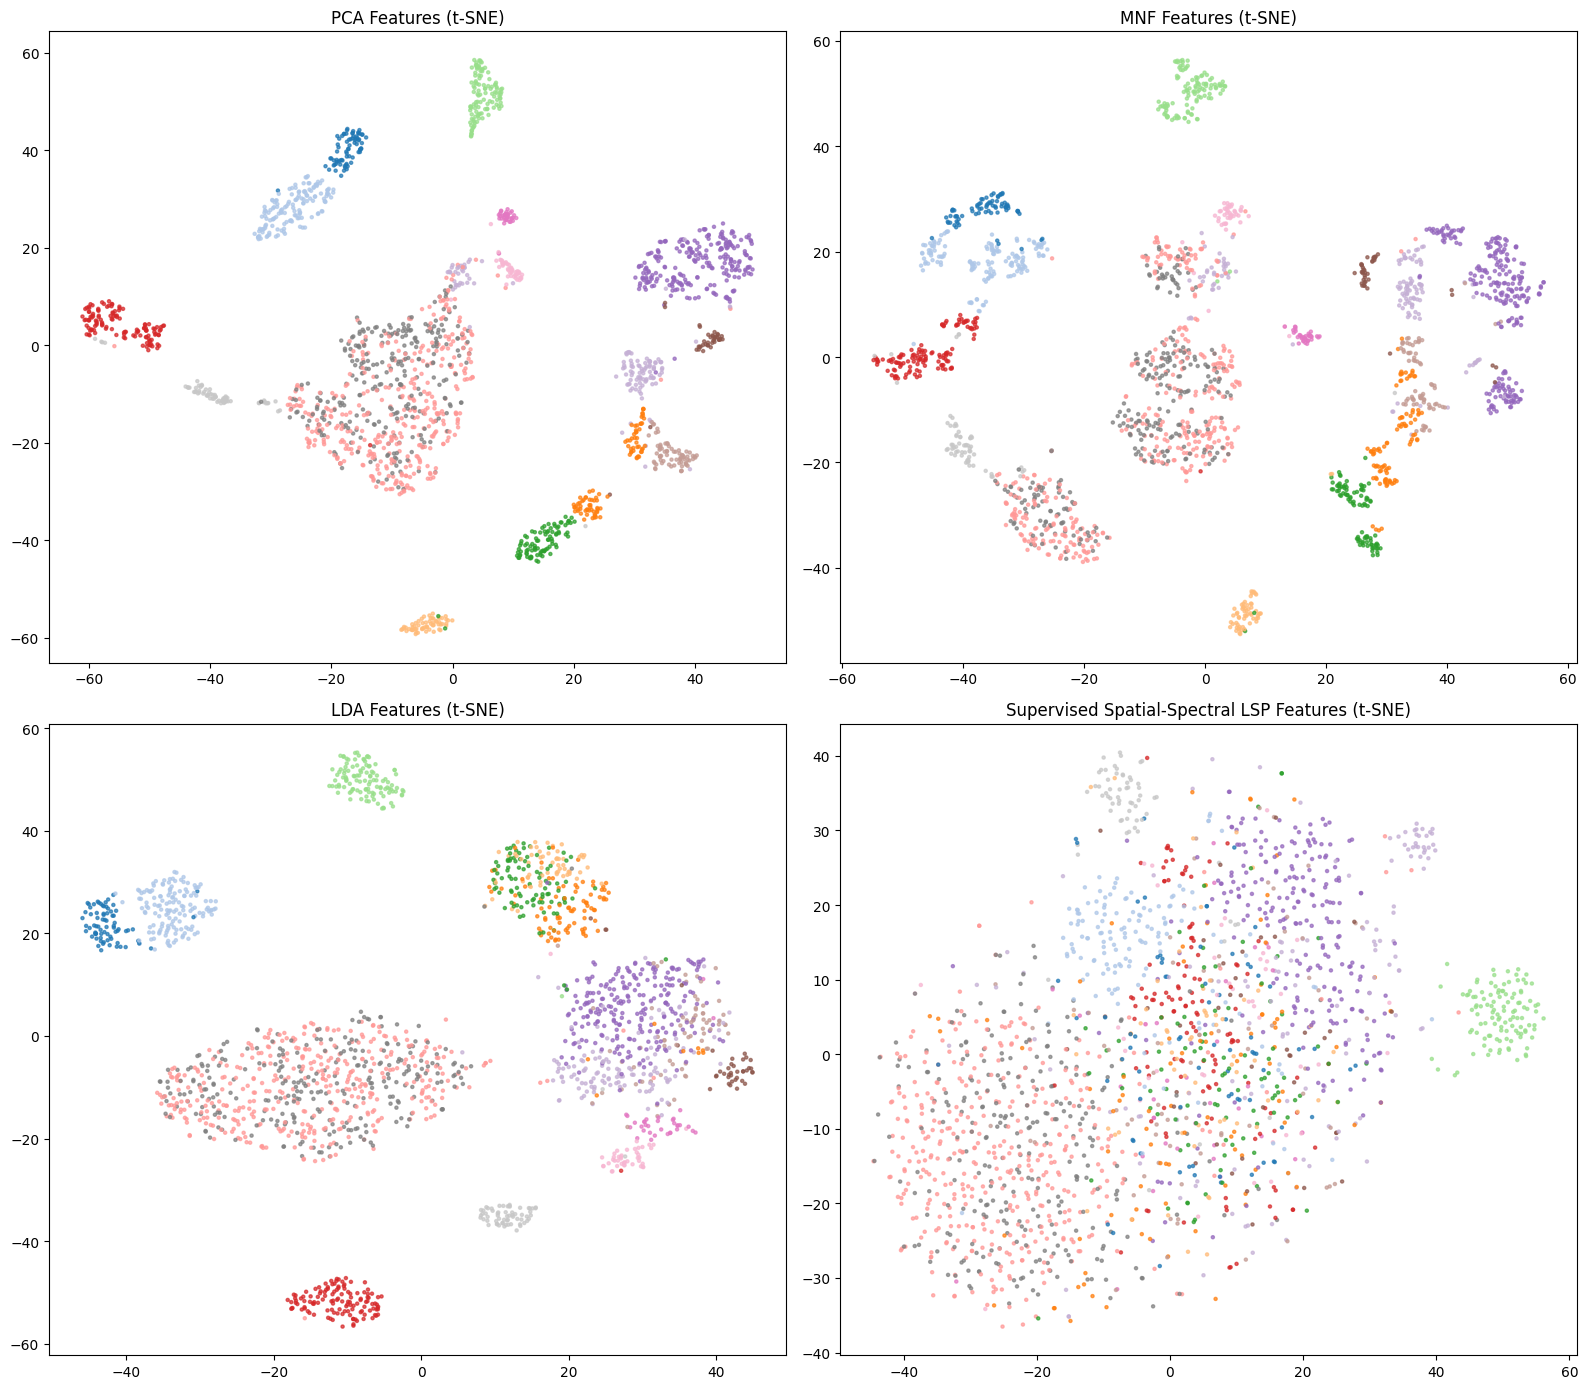

Visualization Concluded.


In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_spaces(samples_per_class=15):
    # Extract a split
    tr_data, te_data, _ = create_few_shot_splits(X, y, coords, samples_per_class=samples_per_class, random_state=42)
    X_tr, y_tr, c_tr = tr_data
    X_te, y_te, c_te = te_data
    
    # We will visualize the test set (or a subset of it) to see generalization
    # For speed, we just take 2000 random test samples
    idx = np.random.choice(len(X_te), min(2000, len(X_te)), replace=False)
    X_vis = X_te[idx]
    y_vis = y_te[idx]
    c_vis = c_te[idx]
    
    dims = 30
    
    # 1. PCA
    pca = PCA(n_components=dims)
    pca.fit(X_tr)
    feat_pca = pca.transform(X_vis)
    
    # 2. MNF
    P_mnf = calculate_mnf(salinas.astype(np.float32))[:, :dims]
    feat_mnf = X_vis @ P_mnf
    
    # 3. LDA
    lda = LDA(n_components=min(dims, len(np.unique(y_tr))-1))
    lda.fit(X_tr, y_tr)
    feat_lda = lda.transform(X_vis)
    
    # 4. Supervised Spatial-Spectral LSP
    # Note: to project test data cleanly we just multiply by P_lsp_ss
    P_lsp_ss = calculate_spatial_spectral_supervised_lsp(X_tr, y_tr, c_tr, d=dims)
    feat_lsp = X_vis @ P_lsp_ss
    
    # Run t-SNE
    print("Running t-SNE for visualizations...")
    tsne_pca = TSNE(n_components=2, random_state=42).fit_transform(feat_pca)
    tsne_mnf = TSNE(n_components=2, random_state=42).fit_transform(feat_mnf)
    tsne_lda = TSNE(n_components=2, random_state=42).fit_transform(feat_lda)
    tsne_lsp = TSNE(n_components=2, random_state=42).fit_transform(feat_lsp)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    cm = sns.color_palette("tab20", len(np.unique(y_vis)))
    
    axes[0,0].scatter(tsne_pca[:, 0], tsne_pca[:, 1], c=[cm[l-1] for l in y_vis], s=5, alpha=0.7)
    axes[0,0].set_title("PCA Features (t-SNE)")
    
    axes[0,1].scatter(tsne_mnf[:, 0], tsne_mnf[:, 1], c=[cm[l-1] for l in y_vis], s=5, alpha=0.7)
    axes[0,1].set_title("MNF Features (t-SNE)")
    
    axes[1,0].scatter(tsne_lda[:, 0], tsne_lda[:, 1], c=[cm[l-1] for l in y_vis], s=5, alpha=0.7)
    axes[1,0].set_title("LDA Features (t-SNE)")
    
    axes[1,1].scatter(tsne_lsp[:, 0], tsne_lsp[:, 1], c=[cm[l-1] for l in y_vis], s=5, alpha=0.7)
    axes[1,1].set_title("Supervised Spatial-Spectral LSP Features (t-SNE)")
    
    plt.tight_layout()
    plt.savefig("dr_comparison.png")
    plt.show()
    print("Visualization Concluded.")
    
plot_feature_spaces(15)
